# Introduction to simple-C-elegans

*original available online: https://github.com/adammarblestone/simple-C-elegans/blob/master/SimulateConnectome.py*

This is essentially a single python script that simulates the nervous system of the C. elegans; with many caveats known to the authors.  The goal is purposeful simplicity to be able to demonstrate the concepts surrounding simulating a nervous system with a reasonable amount of biological detail.  This walkthrough will explain the simple-C-elegans code and how it works.  

A more robust approach is being taken in the OpenWorm project that involves many pieces of infrastructure that are more sophisticated, but also less simple.  Therefore, in addition to explaining how this code works, the larger OpenWorm infrastructure that is responsible for various steps will also be explained along the way.

This notebook resides within the repo at https://github.com/openworm/simple-C-elegans/ 

Original code author: Adam Marblestone

Notebook author: Stephen Larson

### NOTE: For those new to iPython notebooks

If you are viewing this file on GitHub, then you don't have the ability to actively run this code.  If you load this up as an .ipynb in a iPython/Jupyter notebook environment, however, you will have the ability to click on a code block and do a Shift-Enter and the code will RUN.  It is suggested that as you go through this notebook, you RUN each code block in turn, as it will add up to something that can be executed and you can see real results from.

## Getting started: loading missing libraries

First, some practicalities.  The [sci-py libraries](https://www.scipy.org/install.html) are needed to make this run.  One particularly nice setup can be [found here](https://github.com/jupyter/docker-stacks/tree/master/scipy-notebook) with the setup via Docker.

In addition, installing [neuroml](https://github.com/NeuralEnsemble/libNeuroML) will be helpful

## Original code comments

Comments at the top say:
    
>Simulates the dynamics of part or all of the C. elegans neural network.

>This code is *deliberately simple* in order to help the user gain intuition for the qualitative properties of 
the network dynamics.

>Key references include:

> 1) Wicks, Stephen R., Chris J. Roehrig, and Catharine H. Rankin. "A dynamic network simulation of the nematode tap withdrawal circuit: predictions concerning synaptic function using behavioral criteria." The Journal of neuroscience 16.12 (1996): 4017-4031. http://www.ncbi.nlm.nih.gov/pubmed/8656295

> 2) Kunert, James, Eli Shlizerman, and J. Nathan Kutz. "Low-dimensional functionality of complex network dynamics: Neurosensory integration in the Caenorhabditis elegans connectome." Physical Review E 89.5 (2014): 052805. http://arxiv.org/abs/1310.6689

>3) http://www.openworm.org/ and the associated resources

## Library imports

In [1]:
import neuroml
import neuroml.loaders as loaders
import neuroml.writers as writers
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import csv
from scipy.integrate import odeint
import numpy as np
import random
import matplotlib.animation as animation
import time
import pickle
import os

~~Seems like a switch to archive stuff or not.  Not sure why this isn't always true (probably takes more time).~~

It's a switch that determines whether or not the previously calculated DEs are used. Keep false if you tinker with any of the math up to that point.

In [2]:
usePickle = False

## Connectome parameters.

In this section, The code begins by defining the location of the `connectome_spreadsheet`, which is a CSV file that has the connections of the c. elegans in it, based on [work by White et al. 1986](http://rstb.royalsocietypublishing.org/cgi/doi/10.1098/rstb.1986.0056).

Then, we create a variable, `all_the_cell_names`, which will consist of the neurons in the C. elegans nervous system that will be of interest to simulate.

In [3]:
connectome_spreadsheet = "OpenWorm/connectome.csv"

# all the neurons
# all_the_cell_names = ["ADAL","ADAR","ADEL","ADER","ADFL","ADFR","ADLL","ADLR","AFDL","AFDR","AIAL","AIAR","AIBL","AIBR","AIML","AIMR","AINL","AINR","AIYL","AIYR","AIZL","AIZR","ALA","ALML","ALMR","ALNL","ALNR","AQR","AS1","AS2","AS3","AS4","AS5","AS6","AS7","AS8","AS9","AS10","AS11","ASEL","ASER","ASGL","ASGR","ASHL","ASHR","ASIL","ASIR","ASJL","ASJR","ASKL","ASKR","AUAL","AUAR","AVAL","AVAR","AVBL","AVBR","AVDL","AVDR","AVEL","AVER","AVFL","AVFR","AVG","AVHL","AVHR","AVJL","AVJR","AVKL","AVKR","AVL","AVM","AWAL","AWAR","AWBL","AWBR","AWCL","AWCR","BAGL","BAGR","BDUL","BDUR","CEPDL","CEPDR","CEPVL","CEPVR","DA1","DA2","DA3","DA4","DA5","DA6","DA7","DA8","DA9","DB1","DB2","DB3","DB4","DB5","DB6","DB7","DD1","DD2","DD3","DD4","DD5","DD6","DVA","DVB","DVC","FLPL","FLPR","HSNL","HSNR","I1L","I1R","I2L","I2R","I3","I4","I5","I6","IL1DL","IL1DR","IL1L","IL1R","IL1VL","IL1VR","IL2DL","IL2DR","IL2L","IL2R","IL2VL","IL2VR","LUAL","LUAR","M1","M2L","M2R","M3L","M3R","M4","M5","MCL","MCR","MI","NSML","NSMR","OLLL","OLLR","OLQDL","OLQDR","OLQVL","OLQVR","PDA","PDB","PDEL","PDER","PHAL","PHAR","PHBL","PHBR","PHCL","PHCR","PLML","PLMR","PLNL","PLNR","PQR","PVCL","PVCR","PVDL","PVDR","PVM","PVNL","PVNR","PVPL","PVPR","PVQL","PVQR","PVR","PVT","PVWL","PVWR","RIAL","RIAR","RIBL","RIBR","RICL","RICR","RID","RIFL","RIFR","RIGL","RIGR","RIH","RIML","RIMR","RIPL","RIPR","RIR","RIS","RIVL","RIVR","RMDDL","RMDDR","RMDL","RMDR","RMDVL","RMDVR","RMED","RMEL","RMER","RMEV","RMFL","RMFR","RMGL","RMGR","RMHL","RMHR","SAADL","SAADR","SAAVL","SAAVR","SABD","SABVL","SABVR","SDQL","SDQR","SIADL","SIADR","SIAVL","SIAVR","SIBDL","SIBDR","SIBVL","SIBVR","SMBDL","SMBDR","SMBVL","SMBVR","SMDDL","SMDDR","SMDVL","SMDVR","URADL","URADR","URAVL","URAVR","URBL","URBR","URXL","URXR","URYDL","URYDR","URYVL","URYVR","VA1","VA2","VA3","VA4","VA5","VA6","VA7","VA8","VA9","VA10","VA11","VA12","VB1","VB2","VB3","VB4","VB5","VB6","VB7","VB8","VB9","VB10","VB11", "VC1", "VC2", "VC3","VC4","VC5", "VD1", "VD2", "VD3", "VD4", "VD5", "VD6", "VD7", "VD8", "VD9", "VD10", "VD11", "VD12", "VD13"] 

# just the core sensory + interneuron circuit from Wicks + forward motor neurons: DA, VA and AS would need to be added for backwards motion
all_the_cell_names = ["AVM", "AVDL","AVDR", "AVAL","AVAR","AVBL","AVBR","ALML","ALMR","PLML","PLMR","PVCL","PVCR","PVDL","PVDR","DVA","DB1","DB2","DB3","DB4","DB5","DB6","DB7","DD1","DD2","DD3","DD4","DD5","DD6","VB1","VB2","VB3","VB4","VB5","VB6","VB7","VB8","VB9", "VB10","VB11", "VD1", "VD2", "VD3", "VD4", "VD5", "VD6", "VD7", "VD8", "VD9", "VD10", "VD11", "VD12", "VD13"] 

# just the core sensory + interneuron circuit from Wicks
# all_the_cell_names = ["AVM", "AVDL","AVDR", "AVAL","AVAR","AVBL","AVBR","ALML","ALMR","PLML","PLMR","PVCL","PVCR","PVDL","PVDR","DVA"] 

# core sensory + interneuron circuit from Wicks + LUAL and LUAR which the Hiroshima group uses: http://www.bsys.hiroshima-u.ac.jp/pub/pdf/J/J_153.pdf
# all_the_cell_names = ["AVM", "AVDL","AVDR", "AVAL","AVAR","AVBL","AVBR","ALML","ALMR","PLML","PLMR","PVCL","PVCR","PVDL","PVDR","DVA","LUAL","LUAR"] 

# core sensory + interneuron  circuit + LUAL and LUAR + forward motor neurons
#all_the_cell_names = ["AVM", "AVDL","AVDR", "AVAL","AVAR","AVBL","AVBR","ALML","ALMR","PLML","PLMR","PVCL","PVCR","PVDL","PVDR","DVA","LUAL","LUAR", "DB1","DB2","DB3","DB4","DB5","DB6","DB7","DD1","DD2","DD3","DD4","DD5","DD6","VB1","VB2","VB3","VB4","VB5","VB6","VB7","VB8","VB9", "VB10","VB11", "VD1", "VD2", "VD3", "VD4", "VD5", "VD6", "VD7", "VD8", "VD9", "VD10", "VD11", "VD12", "VD13"] 

# core sensory + interneuron  circuit from Wicks + LUAL and LUAR + forward motor neurons + backwards motor neurons
# all_the_cell_names = ["AVM", "AVDL","AVDR", "AVAL","AVAR","AVBL","AVBR","ALML","ALMR","PLML","PLMR","PVCL","PVCR","PVDL","PVDR","DVA","LUAL","LUAR", "DB1","DB2","DB3","DB4","DB5","DB6","DB7","DD1","DD2","DD3","DD4","DD5","DD6","VB1","VB2","VB3","VB4","VB5","VB6","VB7","VB8","VB9", "VB10","VB11", "VD1", "VD2", "VD3", "VD4", "VD5", "VD6", "VD7", "VD8", "VD9", "VD10", "VD11", "VD12", "VD13", "DA1","DA2","DA3","DA4","DA5","DA6","DA7","DA8","DA9","VA1","VA2","VA3","VA4","VA5","VA6","VA7","VA8","VA9","VA10","VA11","VA12", "AS1","AS2","AS3","AS4","AS5","AS6","AS7","AS8","AS9","AS10","AS11"]

l = len(all_the_cell_names)
indices = range(l)

Different commented out variables here have different subsets of neurons that are commented in or out, depending on what combinations of neuron you want to explore computationally.  The first set has all the neurons, but is also the most computationally expensive, meaning your machine may run for an hour or more before returning any results at all.  Other subsets will return results more quickly but will also be less informative.

### OpenWorm Editorial

This is a simple solution to a more general problem of managing the myriad information that is included about these neurons.  OpenWorm's solution to this problem is [PyOpenWorm](http://github.com/openworm/PyOpenWorm).  Rather than enumerating every neuron present, PyOpenWorm provides an abstraction layer over top of the nervous system information that allows for the user to use a higher level API to do similar things.  That said, currently PyOpenWorm introduces [too](https://github.com/openworm/PyOpenWorm/issues/42) [much](https://github.com/openworm/PyOpenWorm/issues/90) of a performance bottleneck for an application like this; it needs to be sped up significantly.

Next, there is the set up of a lot of lists that are going to be populated by functions further down that relate to the connectome:

In [4]:
coords = [] # list of 3D coordinates of all the neurons
cells_connections = {} # synaptic
cells_gaps = {} # gap junctional

connection_nums = {} # synaptic connection nums dict
gap_nums = {} # gap junction connection nums dict

all_adjacency = {} # all synaptic connection nums dict
GABA_adjacency = {} # synaptic connection nums dict specific to GABA
Chol_adjacency = {} # synaptic connection nums dict specific to Acetylcholine
Glut_adjacency = {} # synaptic connection nums dict specific to Glutamate
Other_adjacency = {} # synaptic connection nums dict specific to Other
GABA_Chol_Glut_adjacency = {} # synaptic connection nums dict including everything except "Other"

GABA_expressing = [] # list of pre-synaptic cells expressing GABA
Cholinergic = [] # list of pre-synaptic cells expressing Acetylcholine
Glutamatergic = [] # list of pre-synaptic cells expressing Glutamate
labeled_neuron = "PLML" # give a particular neuron a different color
coords_of_labeled_neuron = (None, None, None)

For now we won't worry about these; there will be more to say about them in the functions that populate these.

## Simulation parameters

We're going to run a simulation in time and we're going to add a stimulus to some of the cells.  How long should the simulation run for?  How long should the stimulus go on for?  How much external current should be added?  And which cells should get the external current?  This section answers these things.

### OpenWorm Editorial

Down here we are getting into the realm of c302.  In [this script](https://github.com/openworm/CElegansNeuroML/blob/9010444482dceeeb704926a805835d41df9f77cc/CElegans/pythonScripts/c302/c302_IClamp.py#L13) you can see examples of both setting offset current (`unphysiological_offset_current`), current delay (`unphysiological_offset_current_del`), duration (`unphysiological_offset_current_dur`) and choosing which cell to stimulate (`cells_to_stimulate`).  This is part of the larger [c302 framework](https://github.com/openworm/CElegansNeuroML/blob/9010444482dceeeb704926a805835d41df9f77cc/CElegans/pythonScripts/c302/README.md) that takes care of a lot of things under the hood, that will come up a few times in this notebook.  One of the things that is a bit complicated in this case is that this particular script generates another file that you then have to know to run with a separate command.

Here are some functions we can use to make other functions in order to stimulate the model.

In [5]:
def masked(f, mask):
    '''Used to make functions that are only supposed to be valued for certain indicies, 
       such as application of a current to just one cell.'''
    return lambda i, t: f(t) * mask[i]

def stepped(f, start, stop):
    '''Make a function return 0 when not in some time range [start, stop)'''
    return lambda t: f(t) if start <= t < stop else 0

def standardize(f, start, stop, mask):
    '''Cleaner way to combine above functions.'''
    return masked(stepped(f, start, stop), mask)

In [6]:
# params of the simulation
I_ext_magnitude = 0.5 * 1e-12 # external current in units of Amperes
stim_dur = 5.0
stim_start = 1.0
start_time = 0.0
end_time = 20.0

# which neurons get external current input
I_ext_mask = [1.0 if all_the_cell_names[i] in ["PLML", "PLMR"] else 0.0 for i in indices] 

standard_pulse = standardize(lambda _: I_ext_magnitude, stim_start, stim_start + stim_dur, I_ext_mask)

## Dynamical parameters.

We're going to set up several parameters that are going to get used in the calculation of the state of the network over time.  If you aren't familiar with the Hodgkin-Huxley style of modelling the membrane potential of a neuron, it is *strongly* recommended you head over to the [Hodgkin-Huxley tutorial](http://hodgkin-huxley-tutorial.readthedocs.io/en/latest/_static/Tutorial.html) which will walk you through the single-cell case in python code and descriptive text.  In addition, it will begin to show you the comparable sections created in a [NeuroML2](http://neuroml.org) manner, which is the underlying infrastructure used by OpenWorm to deal with the increased complexity of the nervous system.

Parameters from the original notebook.

In [7]:
enhanced_synaptic_steepness = 8.0 # Important -- set this to > 1 to increase the nonlinearity: it appears to be effectively set to 1.0, however, in the Kunert and Wicks papers
K = -4.39 * enhanced_synaptic_steepness # pre-factor in the exponential synapse activation
G_c = 100.0 * 1e-12 # cell membrane conductance (S)
C = 10.0 * 1e-12 # cell membrane capacitance (F)
g_syn = 10.0 * 1e-12 # synaptic conductance (S)
g_gap = 5.0 * 1e-12 # gap junctional conductance (S)
G_c_over_C = G_c/C
g_syn_over_C = g_syn/C
g_gap_over_C = g_gap/C
E_c = [-35.0 * 1e-3 for i in indices] # -35 mV leakage potentials
V_range = 35.0 * 1e-3 # 35 mV range
relative_GABA = 0.5 # relative strength of GABA compared to Glut and Chol synapses

Parameters from Kunert et. al

In [8]:
enhanced_synaptic_steepness = 8.0 # Important -- set this to > 1 to increase the nonlinearity: it appears to be effectively set to 1.0, however, in the Kunert and Wicks papers
K = -4.39 * enhanced_synaptic_steepness # pre-factor in the exponential synapse activation
G_c = 10.0 * 1e-12 # cell membrane conductance (S)
C = 1.0 * 1e-12 # cell membrane capacitance (F)
g_syn = 60.0 * 1e-12 # synaptic conductance (S)
g_gap = 30.0 * 1e-12 # gap junctional conductance (S)
G_c_over_C = G_c/C
g_syn_over_C = g_syn/C
g_gap_over_C = g_gap/C
E_c = [-35.0 * 1e-3 for i in indices] # -35 mV leakage potentials
V_range = 35.0 * 1e-3 # 35 mV range
relative_GABA = 0.5 # relative strength of GABA compared to Glut and Chol synapses

## Main loop

In [9]:
def main(f):          
    # get each cell's soma coords
    importData()
    
    # read connectivity data
    readSynapticConnectome()
    readGapConnectome()
    
    # plot the connectome in 3D
    plotConnectomeIn3D()
    
    # plot adjacency matrices
    buildAdjacency()
    plotAdjacency()
    
    # calculate IV curves: this takes a long time so it is usually commented
    # plotIVcurves()
    
    # integrate the ODEs
    soln = integrateODEs(1, f)
    
    print(soln)
    print(soln.shape)
    
    # plot the states of the synaptic parameters
    fig = plt.figure()
    plt.xlabel("Voltage (V)")
    plt.ylabel("Relative pre-synaptic activation || Time (au)")
    plt.title("Comparison of voltages to synaptic activations")
    V_eq = findEquilibriumPotentials()
    V_vals_to_plot = np.linspace(-50 * 1e-3, 0.0 * 1e-3, num = 100, endpoint = True)
    for k in indices:
        plt.plot(V_vals_to_plot, [1.0/(1+np.exp(K*(V_vals_to_plot[i] - V_eq[k])/V_range)) for i in range(len(V_vals_to_plot))], color='r')
        
    for i in indices:
        plt.plot([float(p) for p in soln[:,i]], [1*float(p)/len(soln[:,i]) for p in range(len(soln[:,i]))], color = 'k')
    
    # calculate Jacobian
    calculateJacobian(soln)
    
    # run SVD
    if len(all_the_cell_names) > 18: # this IF statement just checks to be sure there are motor neurons in the simulation to run SVD on!
        runSVD(soln)
    
    # set up plots for the animation
    #setupAnimation(soln)
    
    # show the plots
    plt.show()
    
    return soln

## Where the hardcore math is happening

The computational core of the script is in the next three code blocks describing `integrateODEs()`, `deriv()`, and `findEquilibriumPotentials()`.  Again, using the [Hodgkin-Huxley tutorial](http://hodgkin-huxley-tutorial.readthedocs.io/en/latest/_static/Tutorial.html) will help you to better see what is going on here in the case of a network, by showing you how it looks with a single cell.

After these functions are done running, all the actual simulation of the biophysics of the network has happened, and the rest of the code either analyses what happens or visualizes it.  This is also probably the part that has the biggest computational bottleneck.

### integrateODEs()

This function breaks down into two halves; the first half is actually doing calculation, and the second half is doing plotting of the ODE solutions directly.

#### Part 1: Calculations

The workhorse line is #13 below, where [odeint](http://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html) is getting run.  Basically this takes a system of differential equations and applies [numerical integration](https://en.wikipedia.org/wiki/Numerical_integration) to it to solve it piece-wise over time, giving you values for various quantities you are interested in over time.  

On line #6, the `findEquilibriumPotentials()` function is run, to establish the [resting potential](https://en.wikipedia.org/wiki/Resting_potential) for the cells.  This function will be described more below.

#### Part 2: Plotting

Creates a plot that show the membrane potential changing over time.

In [10]:
def integrateODEs(ext_on, fn):    
    print("\nIntegrating ODEs...")
    
    # inputs to the simulation
    t  = np.linspace(start_time, end_time, num = 500, endpoint = True)
    V_eq = findEquilibriumPotentials()
    F_ext = [ext_on * (I_ext_magnitude / C) * I_ext_mask[i] for i in indices]
    
    if os.path.isfile("ode_soln.p") and usePickle: # delete this file if you want it to run from scratch
        with open("ode_soln.p", "rb" ) as f:
            soln = pickle.load(f)
    else:
        # system starts in equilibrium at time zero
        soln = odeint(deriv, np.array(V_eq), t, args = (V_eq, fn),  mxstep = 5000) 
        with open("ode_soln.p", "wb" ) as f:
            pickle.dump(soln, f)
    
    # plot the ODE solutions
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.set_title("V_m (V)")
    plt.xlabel("Time (s)")
    plt.ylabel("Cell")
    for i in indices[::-1]:
        plt.plot(t, [i for q in range(len(t))], [float(p) for p in soln[:,i]], lw=1.5)
        
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.set_title("V_m - V_eq (V)")
    plt.xlabel("Time (s)")
    plt.ylabel("Cell")
    for i in indices[::-1]:
        plt.plot(t, [i for q in range(len(t))], [float(p) - float(V_eq[i]) for p in soln[:,i]], lw=1.5)
        
    fig = plt.figure()
    plt.xlabel("Time (s)")
    plt.ylabel("Cell")
    plt.ylim(0,len(indices))
    ax = fig.gca()
    ax.pcolor(soln.T)
    ax.set_xticks([0, soln.T.shape[1]])
    ax.set_xticklabels([0, t[-1]])
        
    return soln

### OpenWorm Editorial

Because of the computational cost of doing numerical integration over a large system of equations, the computational neuroscience community has coalesced around a very mature tool known simply as [NEURON](http://neuron.yale.edu).  Under the hood of the c302 framework we are using in the project, is the option to simulate using NEURON.  NEURON has highly efficient algorithms built into it to solve systems of equations in the case of branching neurons.  Even running on single nodes, a noticeable speed up can be appreciated over the performance of odeint as it is being used here.  For more details on the fundamentals of these algorithms (it involves using matrix math), check out [Hines 1984](http://www.sciencedirect.com/science/article/pii/0020710184900084).

Another advantage of NEURON is that it continues to be optimised for high-performance computing.  In particular, NEURON can be run using [MPI on supercomputers](http://www.neuron.yale.edu/neuron/static/docs/help/neuron/neuron/classes/parcon.html#MPI) (although models must be designed to take advantage of parallelism.. no free lunch on that), and it is reported that there is a GPU branch that will be available later this year for gaining efficiency [on single nodes with GPUs](https://www.neuron.yale.edu/phpBB/viewtopic.php?f=31&t=3035) (reportedly not requiring special model design to see an improvement).

As mentioned before, when all the neurons are activated, this script slows down greatly so that it may take an hour or more to complete.  Under NEURON, this would likely only take a minute or two.

## deriv()

This function actually sets up the equations themselves that are going to be numerically integrated.

Lines #9-10 sets up an equation for calculating the current coming from gap junctions, lines #13-14 sets up an equation for calculating the current from synaptic input, and #17 combines them together, along with external input and the voltage of the cell itself from a previous step.

* Lets first look at the equation for I_syn. 

```
    # compute the synaptic input current
    I_syn = [sum([g_syn_over_C * GABA_Chol_Glut_adjacency[all_the_cell_names[j]][all_the_cell_names[i]] \
    * (V[i]-reversal[j])/(1 + np.exp(K*(V[j] - V_eq[j])/V_range)) for j in indices]) for i in indices]
```

That comes from [Wicks et al.](http://www.ncbi.nlm.nih.gov/pubmed/8656295). The term

```
1/(1 + np.exp(K*(V[j] - V_eq[j])/V_range)
```

comes from:


<img src="img/picture1.png" alt="title" style="width: 450px;"/>

Pre-calculated adjacency matricies are created in `buildAdjacency()` (described below), which then is creating hundreds of different equations behind the scenes.  This bit of magic is a bit hidden due to the use of 

`for j in indicies` 

and 

`for i in indices` 

but these mean that the equations set up in #9-10 and #13-14 are actually both in two double for loops.

In [11]:
def deriv(vect,t, V_eq, f):
    '''This function defines the particular set of ODEs used in the simulation. See the documentation for odeint.'''
    
    # -45 mV reversal potential for GABA inhibitory synapses, 0 mV for excitatory
    reversal = [-45 * 1e-3 if all_the_cell_names[i] in GABA_expressing else 0.0 for i in indices] 
    V = list(vect) # prefer working with lists rather than numpy arrays internally
            
    # compute the gap junction input current        
    I_gap = [sum([g_gap_over_C * gap_nums[all_the_cell_names[j]][all_the_cell_names[i]] \
    * (V[i]-V[j]) for j in indices]) for i in indices]
    
    # compute the synaptic input current
    I_syn = [sum([g_syn_over_C * GABA_Chol_Glut_adjacency[all_the_cell_names[j]][all_the_cell_names[i]] \
    * (V[i]-reversal[j])/(1 + np.exp(K*(V[j] - V_eq[j])/V_range)) for j in indices]) for i in indices]
    
    # compute the temporal derivatives
    combined = [G_c_over_C*(E_c[i]-V[i]) - I_gap[i] - I_syn[i] + f(i, t) / C for i in indices]
    
    return np.array(combined)
    


### OpenWorm Editorial

One main difference in this setup of the model from what we are doing over in [c302](https://github.com/openworm/CElegansNeuroML/tree/master/CElegans/pythonScripts/c302) is that the neurons themselves are not given any internal dynamics, such as would come from Calcium ($Ca^{2+}$) or Potassium ($K^+$) channels, as is described in the [Hodgkin-Huxley tutorial](http://hodgkin-huxley-tutorial.readthedocs.io/).  In OpenWorm, we have engaged in the project of determining as precisely as possible all the known ion channels in C. elegans neurons and their dynamics in the [ChannelWorm project](http://github.com/openworm/ChannelWorm).

A second main difference is how the multipicity of equations is managed.  Rather than use adjacency matrices like this, c302 behind the scenes will generate a [LEMS](http://journal.frontiersin.org/article/10.3389/fninf.2014.00079/full) [XML](https://en.wikipedia.org/wiki/XML) file which will create an instance defining all the cells and each connection between them.  This can be seen in the figure below, as the boxes that are generated coming out of "c302_X.py".  This XML file will then get interpreted by libneuroml and get converted into the appropriate NEURON simulation code.  By adding this extra intermediate step, the entire network can be written out in a [declarative form](https://en.wikipedia.org/wiki/Declarative_programming) -- i.e. an XML file -- that completely describes the model using domain concepts that are particular to a biological network model, rather than just systems of equations.  This is valuable as you want to be able to focus on the biological details only and not worry about the equations that will result from them until a later stage.  But, it is also more complex for a developer as you need to keep in mind a few more moving parts in your mind as you work with more abstract files.

The diagram below begins to explain how c302 works.  
<a href="https://docs.google.com/drawings/d/1urLRCe--ymaFTevRWp-etS06E9Rl82b627lC4RmUumI/edit?usp=sharing"><img src="https://docs.google.com/drawings/d/1urLRCe--ymaFTevRWp-etS06E9Rl82b627lC4RmUumI/pub?w=1307&amp;h=712"></a>

## findEquilibriumPotentials()

This method is created to provide initial conditions to the simulation so that cells start off at an appropriate initial membrane potential.  This method is derived from this section in Kunert et al.

<img src="img/picture2.png" alt="title" style="width: 450px;"/>

In [12]:
def findEquilibriumPotentials():
    # -48 mV reversal potential for GABA inhibitory synapses, 0 mV for excitatory
    reversal = [-45 * 0.001 if all_the_cell_names[i] in GABA_expressing else 0.0 for i in indices] 
    conn = GABA_Chol_Glut_adjacency
    gap = gap_nums
    names = all_the_cell_names
    AList = [[None for j in indices] for i in indices]
    bList = [E_c[i] + sum([(g_syn_over_C/G_c_over_C) * conn[names[j]][names[i]] * reversal[j]/2.0 for j in indices]) for i in indices]

    for i in indices:
        AList[i][i] = 1 + sum([(g_gap_over_C/G_c_over_C) * gap[names[j]][names[i]] \
        + (g_syn_over_C/G_c_over_C) * conn[names[j]][names[i]]/2.0 for j in indices])

    for i in indices:
        for j in indices:
            if j != i:
                AList[i][j] = -1 * (g_gap_over_C/G_c_over_C) * gap[names[j]][names[i]]

    AMatrix = np.array(AList)
    bVector = np.array(bList).T # column vector
    
    return [float(k) for k in np.dot(np.linalg.inv(AMatrix), bVector)] # convert to list



### OpenWorm Editorial

In c302, we do not explicitly calculate the equilbrium potentials that start off the simulation, opting instead for the numerical integration of the algorithm to settle the system at the equilibrium value itself.  That said, we do choose initial conditions for the membrane potentials as a starting assumption for the initializations.

## readGapConnectome() & readSynapticConnectome()

These methods very simply read a spreadsheet where the connection graph of the neurons are described.  The two main types of connections are gap junctions and chemical synapses.  The spreadsheet defines both.  In this case, the csv reader loops over the rows of the spreadsheet and builds up data structures `cells_gaps` and `cells_connections`.

In [13]:
def readGapConnectome():
    for k1 in all_the_cell_names:
        gap_nums[k1] = {}
        for k2 in all_the_cell_names:
            gap_nums[k1][k2] = 0.0
    
    with open(connectome_spreadsheet, 'r') as f:
        r = csv.reader(f)
        for row in r:
            if row[2] != "Send":
                if row[0] in all_the_cell_names and row[1] in all_the_cell_names:
                    cells_gaps[row[0]].append(row[1])
                    gap_nums[row[0]][row[1]] = float(row[3])
    


In [14]:
def readSynapticConnectome():
    for k1 in all_the_cell_names:
        connection_nums[k1] = {}
        for k2 in all_the_cell_names:
            connection_nums[k1][k2] = 0.0
    
    with open(connectome_spreadsheet, 'r') as f:
        r = csv.reader(f)
        for row in r:
            if row[2] == "Send":
                if row[0] in all_the_cell_names and row[1] in all_the_cell_names:
                    cells_connections[row[0]].append(row[1])
                    connection_nums[row[0]][row[1]] = float(row[3])
                    if "GABA" in row[4] and not row[0] in GABA_expressing:
                        GABA_expressing.append(row[0])
                    if "Acetylcholine" in row[4] and not row[0] in Cholinergic:
                        Cholinergic.append(row[0])
                    if "Glutamate"  in row[4] and not row[0] in Glutamatergic:
                        Glutamatergic.append(row[0])



### OpenWorm Editorial

In c302, this function is taken care of by the c302.py infrastructure.  Specifically there is a [SpreadsheetDataReader.py](https://github.com/openworm/CElegansNeuroML/blob/d349f85cbc8c471b2202dedf6f2a71e79a6f139b/CElegans/pythonScripts/c302/SpreadsheetDataReader.py) which does this, and is called [within the get_cell_names_and_connections()](https://github.com/openworm/CElegansNeuroML/blob/d349f85cbc8c471b2202dedf6f2a71e79a6f139b/CElegans/pythonScripts/c302/c302.py#L291) method of c302.py.  Alternate experimental versions use a reader that uses PyOpenWorm as the data source instead of the spreadsheet.  These are currently not released as there are performance issues.

## calculateJacobian()


The rest of the code (still translating into notebook-style):

In [15]:
def calculateJacobian(soln):
    print("Calculating Jacobian...")
    # -45 mV reversal potential for GABA inhibitory synapses, 0 mV for excitatory
    reversal = [-45 * 0.001 if all_the_cell_names[i] in GABA_expressing else 0.0 for i in indices] 
    conn = GABA_Chol_Glut_adjacency
    gap = gap_nums
    names = all_the_cell_names
    V = [np.mean(soln.T[i][len(soln.T[i])//2:]) for i in indices]
    V_eq = findEquilibriumPotentials()
    
    J = [[0 for j in indices] for i in indices]
    
    for i in indices: # here we hand-calculate the Jacobian matrix
        J[i][i] = -1 * ((sum([g_gap_over_C * gap[names[j]][names[i]] \
        + g_syn_over_C * conn[names[j]][names[i]]/(1 + np.exp(K*(V[j] - V_eq[j])/V_range)) for j in indices])) + G_c_over_C)
        
        for j in indices:
            if j != i:
                J[i][j] = g_gap_over_C * gap[names[j]][names[i]] \
                + g_syn_over_C * conn[names[j]][names[i]] * (reversal[j] - V[i]) * (K/V_range) \
                * ((1/(1+np.exp(K*(V[j] - V_eq[j])/V_range)))**2) * np.exp(K*(V[j] - V_eq[j])/V_range) 
    
    # plot the complex eigenvalues of the Jacobian matrix
    fig = plt.figure()
    J_matrix = np.array(J)
    eigenvalues = np.linalg.eig(J_matrix)
    reals = eigenvalues[0].real
    imags = eigenvalues[0].imag
    
    plt.title("Eigenvalues of Jacobian at the externally-forced equilbrium")
    plt.xlabel("Real Part")
    plt.ylabel("Imaginary Part")
    plt.vlines([0], -80, 80, linewidth = 5)
    plt.scatter(reals, imags, s = 85)
    


In [16]:
def buildAdjacency():
    # initialize the adjacency matrices
       for k1 in all_the_cell_names:
            all_adjacency[k1] = {}
            GABA_adjacency[k1] = {}
            Chol_adjacency[k1] = {}
            Glut_adjacency[k1] = {}
            Other_adjacency[k1] = {}
            GABA_Chol_Glut_adjacency[k1] = {}
            for k2 in all_the_cell_names:
                all_adjacency[k1][k2] = 0
                GABA_adjacency[k1][k2] = 0
                Chol_adjacency[k1][k2] = 0
                Glut_adjacency[k1][k2] = 0
                Other_adjacency[k1][k2] = 0
                
       # populate adjacency matrices
       for k1 in all_the_cell_names:
           for k2 in all_the_cell_names:
               all_adjacency[k1][k2] 
               if k1 in GABA_expressing:
                   GABA_adjacency[k1][k2] = relative_GABA * connection_nums[k1][k2] # setting the relative strength of inhibition here
               elif k1 in Cholinergic:
                   Chol_adjacency[k1][k2] = connection_nums[k1][k2]
               elif k1 in Glutamatergic:
                   Glut_adjacency[k1][k2] = connection_nums[k1][k2]
               else:
                   Other_adjacency[k1][k2] = connection_nums[k1][k2]
               # this matrix just includes GABAergic, Cholinergic and Glutamatergic synapses
               GABA_Chol_Glut_adjacency[k1][k2] = GABA_adjacency[k1][k2] + Chol_adjacency[k1][k2] + Glut_adjacency[k1][k2] - Other_adjacency[k1][k2]    # From the original script
               # GABA_Chol_Glut_adjacency[k1][k2] = GABA_adjacency[k1][k2] + Chol_adjacency[k1][k2] + Glut_adjacency[k1][k2] Other_adjacency[k1][k2]  # From the notebook
               # GABA_Chol_Glut_adjacency[k1][k2] = GABA_adjacency[k1][k2] + Chol_adjacency[k1][k2] + Glut_adjacency[k1][k2] # Other_adjacency[k1][k2]  # What I think it's supposed to be
               


In [17]:
def plotAdjacency():
    # plot the transmitter-specific adjacency matrices
    # note: this treats e.g. "Serotonin_Acetylcholine" in the spreadsheet as "Acetylcholine"

    pointSizeScaleFactor = 10
    
    # Adjacency matrix for GABA
    fig = plt.figure()
    plt.xlim(0 - pointSizeScaleFactor,
             len(all_the_cell_names) + pointSizeScaleFactor)
    plt.ylim(0 - pointSizeScaleFactor,
             len(all_the_cell_names) + pointSizeScaleFactor)
    plt.xlabel("Input Cell")
    plt.ylabel("Ouput Cell")
    ax = fig.gca()
    ax.set_title("GABA")
    xvalsGABA = []
    yvalsGABA = []
    sizesGABA = []
    for i in range(len(all_the_cell_names)):
        for j in range(len(all_the_cell_names)):
            if GABA_adjacency[all_the_cell_names[i]][all_the_cell_names[j]] > 0:
                xvalsGABA.append(i)
                yvalsGABA.append(j)
                sizesGABA.append(pointSizeScaleFactor*float(GABA_adjacency[all_the_cell_names[i]][all_the_cell_names[j]]))
    plt.scatter(xvalsGABA, yvalsGABA, s = sizesGABA, c = 'r')

    # Adjacency matrix for Acetylcholine
    fig = plt.figure()
    plt.xlim(0 - pointSizeScaleFactor, len(all_the_cell_names) + pointSizeScaleFactor)
    plt.ylim(0 - pointSizeScaleFactor, len(all_the_cell_names) + pointSizeScaleFactor)
    plt.xlabel("Input Cell")
    plt.ylabel("Ouput Cell")
    ax = fig.gca()
    ax.set_title("Acetylcholine")
    xvalsACE = []
    yvalsACE = []
    sizesACE = []
    for i in range(len(all_the_cell_names)):
        for j in range(len(all_the_cell_names)):
            if Chol_adjacency[all_the_cell_names[i]][all_the_cell_names[j]] > 0:
                xvalsACE.append(i)
                yvalsACE.append(j)
                sizesACE.append(pointSizeScaleFactor*float(Chol_adjacency[all_the_cell_names[i]][all_the_cell_names[j]]))
    plt.scatter(xvalsACE, yvalsACE, s = sizesACE, c = 'g')

    # Adjacency matrix for Glutamate
    fig = plt.figure()
    plt.xlim(0 - pointSizeScaleFactor, len(all_the_cell_names) + pointSizeScaleFactor)
    plt.ylim(0 - pointSizeScaleFactor, len(all_the_cell_names) + pointSizeScaleFactor)
    plt.xlabel("Input Cell")
    plt.ylabel("Ouput Cell")
    ax = fig.gca()
    ax.set_title("Glutamate")
    xvalsGLU = []
    yvalsGLU = []
    sizesGLU = []
    for i in range(len(all_the_cell_names)):
        for j in range(len(all_the_cell_names)):
            if Glut_adjacency[all_the_cell_names[i]][all_the_cell_names[j]] > 0:
                xvalsGLU.append(i)
                yvalsGLU.append(j)
                sizesGLU.append(pointSizeScaleFactor*float(Glut_adjacency[all_the_cell_names[i]][all_the_cell_names[j]]))
    plt.scatter(xvalsGLU, yvalsGLU, s = sizesGLU, c = 'b')    

    # Adjacency matrix for other neurotransmitters
    fig = plt.figure()
    plt.xlim(0 - pointSizeScaleFactor, len(all_the_cell_names) + pointSizeScaleFactor)
    plt.ylim(0 - pointSizeScaleFactor, len(all_the_cell_names) + pointSizeScaleFactor)
    plt.xlabel("Input Cell")
    plt.ylabel("Ouput Cell")
    ax = fig.gca()
    ax.set_title("Other Transmitter (Serotonin, Dopamine, etc.)")
    xvalsOTH = []
    yvalsOTH = []
    sizesOTH = []
    for i in range(len(all_the_cell_names)):
        for j in range(len(all_the_cell_names)):
            if Other_adjacency[all_the_cell_names[i]][all_the_cell_names[j]] > 0:
                xvalsOTH.append(i)
                yvalsOTH.append(j)
                sizesOTH.append(pointSizeScaleFactor*float(Other_adjacency[all_the_cell_names[i]][all_the_cell_names[j]]))
    plt.scatter(xvalsOTH, yvalsOTH, s = sizesOTH, c = 'm')

    # Adjacency matrix for gap junctions
    fig = plt.figure()
    plt.xlim(0 - pointSizeScaleFactor, len(all_the_cell_names) + pointSizeScaleFactor)
    plt.ylim(0 - pointSizeScaleFactor, len(all_the_cell_names) + pointSizeScaleFactor)
    plt.xlabel("Input Cell")
    plt.ylabel("Ouput Cell")
    ax = fig.gca()
    ax.set_title("Gap Junctions")
    xvalsGAP = []
    yvalsGAP = []
    sizesGAP = []                
    for i in range(len(all_the_cell_names)):
        for j in range(len(all_the_cell_names)):
            if gap_nums[all_the_cell_names[i]][all_the_cell_names[j]] > 0:
                xvalsGAP.append(i)
                yvalsGAP.append(j)
                sizesGAP.append(pointSizeScaleFactor*float(gap_nums[all_the_cell_names[i]][all_the_cell_names[j]]))
    plt.scatter(xvalsGAP, yvalsGAP, s = sizesGAP, c = 'k')
    
    
    # Adjacency matrix for All neurotransmitters
    
    fig = plt.figure()
    plt.xlim(0 - pointSizeScaleFactor, len(all_the_cell_names) + pointSizeScaleFactor)
    plt.ylim(0 - pointSizeScaleFactor, len(all_the_cell_names) + pointSizeScaleFactor)
    plt.xlabel("Input Cell")
    plt.ylabel("Ouput Cell")
    ax = fig.gca()
    ax.set_title("All Transmitters")
    plt.scatter(xvalsGABA, yvalsGABA, s = sizesGABA, c = 'r')
    plt.scatter(xvalsACE, yvalsACE, s = sizesACE, c = 'g')
    plt.scatter(xvalsGLU, yvalsGLU, s = sizesGLU, c = 'b')
    plt.scatter(xvalsOTH, yvalsOTH, s = sizesOTH, c = 'm')
    plt.scatter(xvalsGAP, yvalsGAP, s = sizesGAP, c = 'k')
    plt.legend(['GABA', 'Acetylcholine', 'Glutamate', 'Other', 'Gap Junctions'], loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=5)




In [18]:
def plotIVcurves():
    print("\nCalculating IV curves...")
    t  = np.linspace(0.0, 2.0, num = 2, endpoint = True)
    V_eq = findEquilibriumPotentials()
    stim_dur = 10
    stim_start = 0.0
    range_of_currents = np.linspace(-50,50, num = 20, endpoint = True)
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.set_title("Steady-State Voltage (V)")
    plt.xlabel("Injected Current (pA)")
    plt.ylabel("Cell")
    
    for k in indices[::-1]:
        Vvals = []
        I_ext_mask = [1.0 if i == k else 0.0 for i in indices] # select which neurons get external current input
        for external_current_input in range_of_currents: # this is in units of G_c
            I_ext_magnitude = external_current_input * 1.0e-12 # external current in units of Amperes
            F_ext = [(I_ext_magnitude / C) * I_ext_mask[i] for i in indices] # external contribution to voltage dynamics
            # system starts in equilibrium at time zero
            soln = odeint(deriv, np.array(V_eq), t, args = (F_ext,V_eq, stim_dur, stim_start),  mxstep = 5000)
            steady_state_voltages = [float(p) for p in soln[-1,:]]
            Vvals.append(steady_state_voltages[k])
        plt.plot(range_of_currents,[k for m in range_of_currents], Vvals, lw=3.5)
        


In [19]:
def getSegmentIds(cell): # from OpenWorm code
    seg_ids = []
    for segment in cell.morphology.segments:
        seg_ids.append(segment.id)

    return seg_ids



In [20]:
def get3DPosition(cell, segment_index, fraction_along): # from OpenWorm code
    seg = cell.morphology.segments[segment_index]
 
    end = seg.distal

    start = seg.proximal
    if start is None:
        segs = getSegmentIds(cell)
        seg_index_parent = segs.index(seg.parent.segments)
        start = cell.morphology.segments[seg_index_parent].distal

    fx = fract(start.x, end.x, fraction_along)
    fy = fract(start.y, end.y, fraction_along)
    fz = fract(start.z, end.z, fraction_along)

    return fx, fy, fz



In [21]:
def fract(a, b, f): # from OpenWorm code
    return a+(b-a)*f
    


In [22]:
def importData():
    global coords_of_labeled_neuron
    
    for cellName in all_the_cell_names:
        inFile = "OpenWorm/straightenedNeuroML2/" + cellName + ".nml"

        # open the cell
        doc = loaders.NeuroMLLoader.load(inFile)
        if not doc.cells:
            sys.exit(1)
        cell = doc.cells[0]

        # find the soma coordinates
        c = get3DPosition(cell, 0, 0.5)
        if cellName == labeled_neuron:
            coords_of_labeled_neuron = c
        coords.append(c)
        cells_connections[cellName] = [c]
        cells_gaps[cellName] = [c]
    


In [23]:
def plotConnectomeIn3D():
    # set up the plot
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.set_xlim3d(-30,30)
    ax.set_ylim3d(-400,400)
    ax.set_zlim3d(-30,30)
    plt.xlabel(r"x ($\mu$m)")
    plt.ylabel(r"y ($\mu$m)")
    
    # plot the synaptic connections in 3D
    k = cells_connections.keys()
    for key in k:
        s = cells_connections[key][0]    
        end_coords_list = [cells_connections[p][0] for p in cells_connections[key][1:]]
        for i in range(len(end_coords_list)):
            e = end_coords_list[i]
            p = cells_connections[key][1:][i]

            num = float(connection_nums[key][p])
            if key in GABA_expressing:
                ax.plot([s[0], e[0]], [s[1], e[1]], [s[2], e[2]], color='r', linestyle='dashed', linewidth = num)
            elif key in Cholinergic:
                # pass
                ax.plot([s[0], e[0]], [s[1], e[1]], [s[2], e[2]], color='g', linestyle='dashed', linewidth = num/3)
            elif key in Glutamatergic:
                # pass
                ax.plot([s[0], e[0]], [s[1], e[1]], [s[2], e[2]], color='b', linestyle='dashed', linewidth = num/3)
            else:
                # pass
                ax.plot([s[0], e[0]], [s[1], e[1]], [s[2], e[2]], color='m', linestyle='dashed', linewidth = num/3)
    
    # plot the gap junctions in 3D
    k = cells_gaps.keys()
    for key in k:
        s = cells_gaps[key][0]
        end_coords_list = [cells_gaps[p][0] for p in cells_gaps[key][1:]]
        for i in range(len(end_coords_list)):
            e = end_coords_list[i]
            p = cells_gaps[key][1:][i]
            num = float(gap_nums[key][p])
            ax.plot([s[0], e[0]], [s[1], e[1]], [s[2], e[2]], color='k', linestyle='dotted', linewidth = num/3)
            
    # plot the soma coordinates in 3D
    ax.plot([c[0] for c in coords], [c[1] for c in coords], [c[2] for c in coords], 'o', color='k', alpha=1)
            
    # plot the labeled neuron in 3D
    ax.plot([coords_of_labeled_neuron[0]], [coords_of_labeled_neuron[1]], [coords_of_labeled_neuron[2]], 'o', color='y',ms=10.0, alpha=1)
    


## runSVD()


<img src="img/SVD_phase_space.png" alt="title" style="width: 450px;"/>

<img src="img/SVD_mode_dynamics.png" alt="title" style="width: 450px;"/>

<img src="img/SVD_modes_of_motor_neurons.png" alt="title" style="width: 450px;"/>

In [24]:
def runSVD(soln):
    print("SVD analysis...")
    motor_neuron_indices = indices[18:] # the first 18 neurons are the sensory neurons and interneurons
    # Time-slices of motor neurons, starting halfway through the simulation to allow the initial transients to settle
    
    M = np.array([[k - np.mean(soln.T[i][len(soln.T[i])//2:]) for k in soln.T[i][len(soln.T[i])//2:]] for i in motor_neuron_indices]) 
    
    # breaks somewhere in here.
    U, S, V = np.linalg.svd(M)
    fig = plt.figure()
    plt.xlabel("Mode number")
    plt.ylabel("Fractional contribution")
    plt.title("Singular values")
    plt.xlim(0, len(S)+1)
    plt.ylim(0,1)
    
    plt.scatter(range(1,len(S)+1),[p for p in S]/sum([q for q in S]), s=50)
    
    # plot the dynamics of the modes
    firstmode_vec = U[:,0]/np.linalg.norm(U[:,0])
    secondmode_vec = U[:,1]/np.linalg.norm(U[:,1])
    thirdmode_vec = U[:,2]/np.linalg.norm(U[:,2])
    
    # plot the modes as vectors
    fig = plt.figure()
    plt.title("Mode vectors")
    plt.xlabel("Motor neuron number")
    plt.ylabel("Mode weight on neuron")
    plt.plot(firstmode_vec, linewidth = 3, marker = 'o', markersize = 15)
    plt.plot(firstmode_vec, linewidth = 3, marker = 'o', markersize = 15)
    plt.plot(firstmode_vec, linewidth = 3, marker = 'o', markersize = 15)
    
    a1 = []
    a2 = []
    a3 = []
    for i in range(np.shape(M)[1]):
        timeslice = M[:,i]
        a1.append((timeslice.T @ firstmode_vec))
        a2.append((timeslice.T @ secondmode_vec))
        a3.append((timeslice.T @ thirdmode_vec))
        
    fig = plt.figure()
    plt.title("Shapes of the first three modes")
    plt.xlabel("Time (au)")
    plt.ylabel("Mode amplitude (au)")
    plt.plot(a1, linewidth = 2)
    plt.plot(a2, linewidth = 2)
    plt.plot(a3, linewidth = 2)
    plt.figure()
    plt.title("Mode phase space evolution")
    plt.xlabel("Mode")
    plt.ylabel("Mode")
    plt.plot(a1, a2, linewidth = 1)


In [25]:
def setupAnimation(soln):
    print("Animation...")
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.set_xlim3d(-30,30)
    ax.set_ylim3d(-400,400)
    ax.set_zlim3d(-30,30)
    plt.xlabel(r"x ($\mu$m)")
    plt.ylabel(r"y ($\mu$m)")
    
    # animate the activity
    lastframe = 200
    numframes = len(soln[:lastframe,0])
    numpoints = len(coords)
    V_eq = findEquilibriumPotentials()
    color_data = np.array([[10*np.abs(s[p]) for p in range(numpoints)] for s in soln[:lastframe]]) 
    scat = ax.scatter([x[0] for x in coords], [x[1] for x in coords], [x[2] for x in coords], s = 85)
    ani = animation.FuncAnimation(fig, update_plot, frames = range(len(soln[:lastframe,0])), fargs = (color_data, scat), blit=False, interval = 1)

    # save the animation to a file: need to install ffmpeg for this to work
    # on my Mac it worked to do "sudo port install ffmpeg" after installing MacPorts
    FFwriter = animation.FFMpegWriter() # write the animation to a file
    ani.save('network_sim.mp4', writer = FFwriter, fps=1000, extra_args=['-vcodec', 'libx264'])



In [26]:
def update_plot(i, data, scat):
    scat.set_array(data[i])
    return scat
    



Integrating ODEs...
[[-0.01205615 -0.00249621 -0.0014     ... -0.00875    -0.005
  -0.035     ]
 [-0.01205615 -0.00249621 -0.0014     ... -0.00875    -0.005
  -0.035     ]
 [-0.01205615 -0.00249621 -0.0014     ... -0.00875    -0.005
  -0.035     ]
 ...
 [-0.01166824 -0.00194667 -0.00109885 ... -0.00811533 -0.00458978
  -0.03853356]
 [-0.01166824 -0.00194667 -0.00109885 ... -0.00811533 -0.00458978
  -0.03853356]
 [-0.01166824 -0.00194667 -0.00109885 ... -0.00811533 -0.00458978
  -0.03853356]]
(500, 53)
Calculating Jacobian...
SVD analysis...


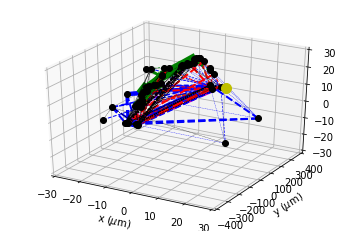

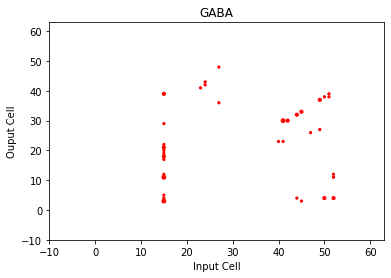

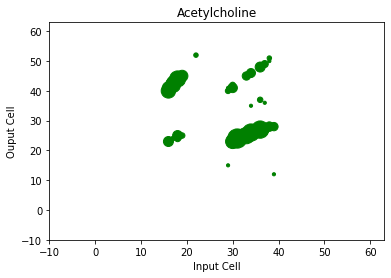

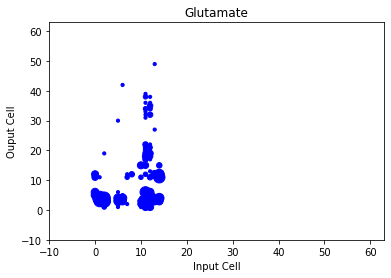

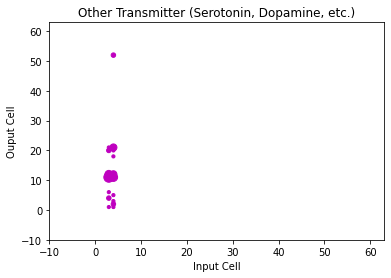

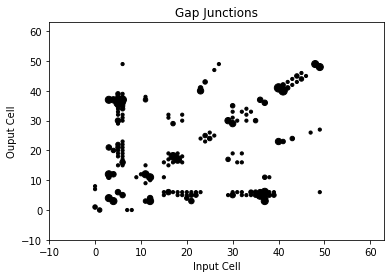

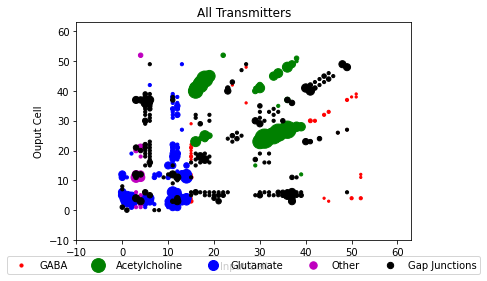

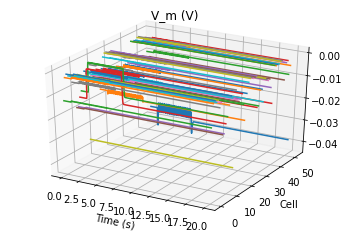

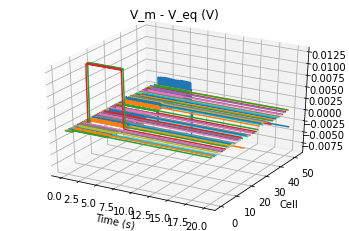

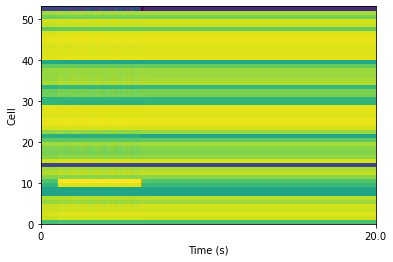

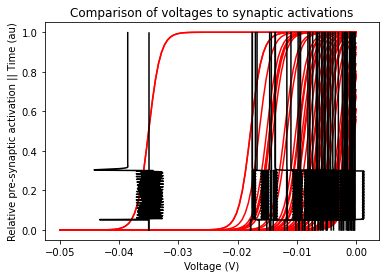

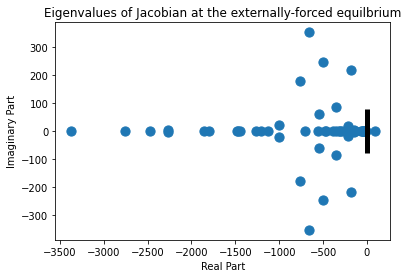

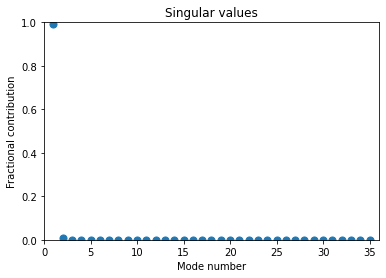

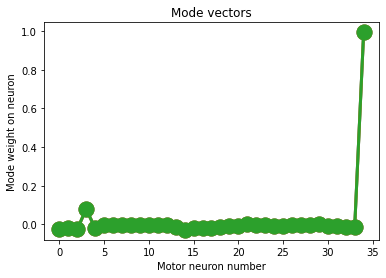

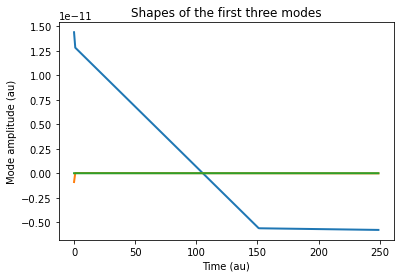

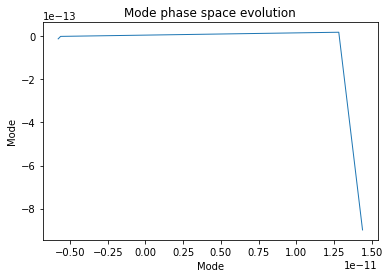

In [27]:
soln = main(standard_pulse)